## CENÁRIO 02 - MODELO CORINGA 

IMPORTS

In [1]:
import pandas as pd
import simpy
import os
import re
from unidecode import unidecode
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import numpy as np
import matplotlib.patches as mpatches
from datetime import date, timedelta
from reportlab.lib.pagesizes import A4
from reportlab.pdfgen import canvas

### ETAPA 1 - Obtendo informações de tempo do Yamazumi

In [2]:


# OBTENDO TEMPOS POR ATIVIDADES DOS ARQUIVOS YAMAZUMI 
def get_process_times_from_csv(arquivo):
    """Lê um CSV Yamazumi, extrai os tempos por atividade e retorna um dicionário {atividade: tempo_em_segundos}."""
    
    def converter_tempo_para_segundos(tempo_str):
        if pd.isna(tempo_str) or not isinstance(tempo_str, str):
            return 0
        parts = str(tempo_str).split(':')
        try:
            if len(parts) == 3:
                h, m, s = map(int, parts)
                return h * 3600 + m * 60 + s
            elif len(parts) == 2:
                m, s = map(int, parts)
                return m * 60 + s
        except Exception:
            return 0
        return 0

    if not os.path.exists(arquivo):
        return {}

    df = pd.read_csv(arquivo, header=5, sep=';', encoding='latin1', on_bad_lines='skip')

    def normalizar_coluna(col):
        col = unidecode(col)
        col = col.upper()
        col = re.sub(r"[\"\'().\-\/]", "", col)
        col = re.sub(r"\s+", "_", col)
        return col.strip("_")

    df.columns = [normalizar_coluna(col) for col in df.columns]

    class_col = next((col for col in df.columns if 'CLASSIFICA' in col), None)
    if not class_col:
        return {}

    total_row = df[df[class_col] == 'Total'].copy()
    if total_row.empty:
        return {}

    start_col = df.columns.get_loc(class_col) + 1
    end_col = len(df.columns)
    try:
        end_col = df.columns.get_loc('COLUNA1')
    except KeyError:
        pass

    colunas_postos = df.columns[start_col:end_col]
    tempos_totais = total_row[colunas_postos].dropna(axis=1, how='all')
    tempos_formatados = tempos_totais.melt(var_name='Atividade', value_name='Tempo_str')
    tempos_formatados['Tempo_segundos'] = tempos_formatados['Tempo_str'].apply(converter_tempo_para_segundos)

    return pd.Series(tempos_formatados.Tempo_segundos.values, index=tempos_formatados.Atividade).to_dict()



### ETAPA 02: Criando dicionário de tempos por posto

##### Configuração perna 1: 
19 operadores no total sendo 1 por atividade, com excessões: 
- DIESEL - 30A  
- ARREFEC - 31A  
- REAPERTO - 32A  
- 5AA_RODA - 32C (só ATP)  
- ESTEPE - 32C  
- PNEU_LE + PNEU_LD - 33A (2 operadores)  
- APERTO_LE + APERTO_LD - 34A (2 operadores)  
- GRADE- 34A  
- MECACNICA_1 + MECACNICA_2 - Início: 34A; Fim: 38 (2 operadores)  
- ELECTRICA_1 + ELECTRICA_2 - Início: 32A; Fim: 33A (2 operadores)  
- CONTROLE - 34A  
- MOTORISTA - 38  
- QUIS - 38  




##### Configuração perna 2:
13 operadores no total sendo 1 por atividade, com excessões: 
- PASSADISASSO - 30B 
- ABASTECIMENTO - 31B   
- CHINELEIRA - 32B  
- 5AA_RODA - 32D  
- PNEU_LE + PNEU_LD - 33B (2 operadores)  
- PARALAMA_LD + PARALAMA_LE - 34B (1 op)  
Paralama e pneu é feito ao mesmo tempo, assim, tempo paralama conta como 1
- CONTROLE - 34B 
- ELACTRICA_I + ELACTRICA_II + ELACTRICA_III - Início: 33B; Fim: 39 (3 operadores)  
Na elétrica, podemos considerar como se 1 operador fizesse 1 atvidade total distribuída pelos 3 postos  


In [3]:

# --- Dicionários ---
MODELOS_CSV = {
    "Accelo": {"baumuster": ["C951102", "C951104", "C951111"], "perna": [1], "tempos": "Yamazumi - Accelo.csv"},
    "Atego": {"baumuster":["C951500", "C951501", "C951511", "C951514", "C951530", "C951544"],"perna": [1], "tempos":"Yamazumi - Atego.csv"},
    "Atego (ATP)":{"baumuster": ["C968403", "C968114"], "perna": [1,2], "tempos":"Yamazumi - ATP.csv"}, 
    "Actros":{"baumuster": ["C963400", "C963403", "C963411", "C963414", "C963424", "C963425"], "perna": [2], "tempos":"Yamazumi - Actros.csv"},
    "Arocs": {"baumuster":["C964016", "C964216", "C964231", "C964416"], "perna": [2], "tempos":"Yamazumi - Arocs.csv"},
    "Axor (ATP +)":{"baumuster": ["C968150", "C968450", "C968453", "C968461", "C968475"], "perna":[2], "tempos": "Yamazumi - Actros.csv"}
}

ATIVIDADES_P1 = {'DIESEL':{'postos':['30A'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              'ARREFEC':{'postos':['31A'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              'REAPERTO':{'postos':['32A'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              '5AA_RODA':{'postos':['32C'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              'ESTEPE':{'postos':['32C'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              'APERTO_LE':{'postos':['32C'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              'PNEU_LD':{'postos':['33A'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1}, 
              'PNEU_LE':{'postos':['33A'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              'APERTO_LD':{'postos':['34A'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              'GRADE':{'postos':['34A'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              'MECACNICA_1':{'postos':['34A','38'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              'MECACNICA_2':{'postos':['34A','38'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              'ELACTRICA_1':{'postos':['32A','32C','33A'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              'ELACTRICA_2':{'postos':['32A','32C','33A'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              'CONTROLE':{'postos':['34A'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              'MOTORISTA':{'postos':['38'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              'QUIS':{'postos':['38'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              }

ATIVIDADES_P2 = {'PASSADISASSO':{'postos':['30B'],'modelos':['Actros','Arocs', 'Axor (ATP +)'],'operadores':1},
              'ABASTECIMENTO':{'postos':['31B'],'modelos':['Actros','Arocs', 'Axor (ATP +)'],'operadores':1},
              'CHINELEIRA':{'postos':['32B'],'modelos':['Actros','Arocs', 'Axor (ATP +)'],'operadores':1},
              '5AA_RODA': {'postos':['32D'],'modelos':['Actros','Arocs', 'Axor (ATP +)','Atego (ATP)'],'operadores':2},
              'PNEU_LD':{'postos':['33B'],'modelos':['Actros','Arocs', 'Axor (ATP +)','Atego (ATP)'],'operadores':1}, 
              'PNEU_LE':{'postos':['33B'],'modelos':['Actros','Arocs', 'Axor (ATP +)','Atego (ATP)'],'operadores':1},
              'PARALAMA_LD': {'postos':['34B'],'modelos':['Actros','Arocs', 'Axor (ATP +)'],'operadores':1},#mesmo operador que o de aperto_ld e le
              'PARALAMA_LE':{'postos':['34B'],'modelos':['Actros','Arocs', 'Axor (ATP +)'],'operadores':1},
              'CONTROLE': {'postos':['34B'],'modelos':['Actros','Arocs', 'Axor (ATP +)','Atego (ATP)'],'operadores':1},
              'ELACTRICA_I':{'postos':['33B','34B','39'],'modelos':['Actros','Arocs', 'Axor (ATP +)'],'operadores':1},
              'ELACTRICA_II':{'postos':['33B','34B','39'],'modelos':['Actros','Arocs', 'Axor (ATP +)'],'operadores':1},
              'ELACTRICA_III':{'postos':['33B','34B','39'],'modelos':['Actros','Arocs', 'Axor (ATP +)'],'operadores':0},
              
              #Atividades da p1 que foram para a p2 também
              'DIESEL':{'postos':['30B'],'modelos':['Atego (ATP)'],'operadores':1},
              'ARREFEC':{'postos':['31B'],'modelos':['Atego (ATP)'],'operadores':1},
              'REAPERTO':{'postos':['32B'],'modelos':['Atego (ATP)'],'operadores':1},
              'ESTEPE':{'postos':['32D'],'modelos':['Atego (ATP)'],'operadores':1},
              'APERTO_LE':{'postos':['32D'],'modelos':['Atego (ATP)'],'operadores':1},
              'APERTO_LD':{'postos':['34B'],'modelos':['Atego (ATP)'],'operadores':1},
              'GRADE':{'postos':['34B'],'modelos':['Atego (ATP)'],'operadores':1},
              'MECACNICA_1':{'postos':['34B','39'],'modelos':['Atego (ATP)'],'operadores':1},
              'MECACNICA_2':{'postos':['34A','39'],'modelos':['Atego (ATP)'],'operadores':1},
              'ELACTRICA_1':{'postos':['33B','34B','39'],'modelos':['Atego (ATP)'],'operadores':1},
              'ELACTRICA_2':{'postos':['33B','34B','39'],'modelos':['Atego (ATP)'],'operadores':1},
              'MOTORISTA':{'postos':['39'],'modelos':['Atego (ATP)'],'operadores':1},
              'QUIS':{'postos':['39'],'modelos':['Atego (ATP)'],'operadores':1},
               }


In [4]:
# def gerar_dicionario_postos(MODELOS_CSV, ATIVIDADES_P1, ATIVIDADES_P2, get_process_times_from_csv):
#     # Ordem dos postos por perna
#     ordem_P1 = ['30A', '31A', '32A', '32C', '33A', '34A', '38']
#     ordem_P2 = ['30B', '31B', '32B', '32D', '33B', '34B', '39']

#     # Resultado final
#     POSTOS = {}

#     # Regras/grupos especiais (mantidas)
#     GRUPOS_ESPECIAIS = {
#         'P1': {
#             'PNEU': {"atividades": ['PNEU_LE', 'PNEU_LD'], "agreg": "media"},
#             'APERTO': {"atividades": ['APERTO_LE', 'APERTO_LD'], "agreg": "media"},
#             'MECACNICA': {"atividades": ['MECACNICA_1', 'MECACNICA_2'], "agreg": "media"},
#             'ELETRICA': {"atividades": ['ELACTRICA_1', 'ELACTRICA_2'], "agreg": "media"},
#         },
#         'P2': {
#             'PNEU': {"atividades": ['PNEU_LE', 'PNEU_LD'], "agreg": "media"},
#             'PARALAMA': {"atividades": ['PARALAMA_LE', 'PARALAMA_LD'], "agreg": "paralama"},
#             'APERTO': {"atividades": ['APERTO_LE', 'APERTO_LD'], "agreg": "novo"},
#             'MECACNICA': {"atividades": ['MECACNICA_1', 'MECACNICA_2'], "agreg": "novo"},
#             'ELETRICA': {"atividades": ['ELACTRICA_1', 'ELACTRICA_2'], "agreg": "novo"},
#             'ELECTRICA': {"atividades": ['ELACTRICA_I', 'ELACTRICA_II'], "agreg": "novo"},
#             'DIESEL_PASSADISSO': {'atividades': ['DIESEL', 'PASSADISASSO'], 'agreg': 'novo'},
#             'ARREFEC_ABASTECIMENTO': {'atividades': ['ARREFEC', 'ABASTECIMENTO'], 'agreg': 'novo'},
#             'REAPERTO_CHINELEIRA': {'atividades': ['REAPERTO', 'CHINELEIRA'], 'agreg': 'novo'},
#             '5AA_RODA_ESTEPE': {'atividades': ['ESTEPE', '5AA_RODA'], 'agreg': 'novo'},
#             'GRADE_CONTROLE_MOTORISTA_QUIS': {'atividades': ['GRADE', 'CONTROLE', 'MOTORISTA', 'QUIS'], 'agreg': 'novo'},
#         }
#     }

#     # Para contagem de operadores por perna (atividades únicas vistas por perna)
#     atividades_unicas_por_perna = {1: set(), 2: set()}

#     for modelo, dados_modelo in MODELOS_CSV.items():
#         perna_list = dados_modelo["perna"]          # << agora é lista (ex.: [1], [2] ou [1,2])
#         arquivo = dados_modelo["tempos"]
#         tempos_atividade = get_process_times_from_csv(arquivo)

#         # dicionário dos postos desse modelo (agrega sobre múltiplas pernas)
#         dicionario_postos = {}

#         # Itera por cada perna aplicável ao modelo
#         for perna in perna_list:
#             atividades_dict = ATIVIDADES_P1 if perna == 1 else ATIVIDADES_P2
#             ordem_postos = ordem_P1 if perna == 1 else ordem_P2
#             grupos = GRUPOS_ESPECIAIS['P1'] if perna == 1 else GRUPOS_ESPECIAIS['P2']

#             # 1) Aplica regras dos grupos especiais
#             for _, grupo in grupos.items():
#                 atividades = grupo["atividades"]
#                 # só aplica se todas as atividades existem no CSV e na tabela de atividades desta perna
#                 if not all(a in tempos_atividade and a in atividades_dict for a in atividades):
#                     continue

#                 # registra atividades vistas para contagem de operadores
#                 for a in atividades:
#                     atividades_unicas_por_perna[perna].add(a)

#                 # como combinar tempos dos itens do grupo
#                 if grupo["agreg"] == "media":
#                     tempo_total = sum(tempos_atividade[a] / atividades_dict[a]['operadores'] for a in atividades)
#                     tempo_agregado = tempo_total / len(atividades)

#                 elif grupo["agreg"] == "paralama":
#                     tempo_total = sum(tempos_atividade[a] for a in atividades)
#                     total_operadores = sum(atividades_dict[a]['operadores'] for a in atividades) / 2
#                     tempo_agregado = tempo_total / (total_operadores if total_operadores else 1)

#                 elif grupo["agreg"] == "novo":
#                     # regra: 1 operador cobre o grupo todo
#                     tempo_total = sum(tempos_atividade[a] for a in atividades)
#                     tempo_agregado = tempo_total  # dividido por 1

#                 else:
#                     continue

#                 # distribui entre todos os postos envolvidos pelas atividades do grupo
#                 postos_grupo = sorted(set(p for a in atividades for p in atividades_dict[a]['postos']))
#                 if not postos_grupo:
#                     continue
#                 quota = tempo_agregado / len(postos_grupo)

#                 for posto in postos_grupo:
#                     # cria/atualiza registro do posto
#                     entry = dicionario_postos.setdefault(posto, {"tempo_tot": 0, "perna": []})
#                     entry["tempo_tot"] += quota
#                     if perna not in entry["perna"]:
#                         entry["perna"].append(perna)

#             # 2) Atividades “normais” (não agrupadas)
#             for atividade, props in atividades_dict.items():
#                 if modelo not in props['modelos']:
#                     continue
#                 if atividade not in tempos_atividade:
#                     continue

#                 atividades_unicas_por_perna[perna].add(atividade)

#                 tempo = tempos_atividade[atividade] / (props['operadores'] if props['operadores'] else 1)
#                 for posto in props['postos']:
#                     entry = dicionario_postos.setdefault(posto, {"tempo_tot": 0, "perna": []})
#                     entry["tempo_tot"] += tempo
#                     if perna not in entry["perna"]:
#                         entry["perna"].append(perna)

#         # 3) Ordena os postos para o modelo
#         if perna_list == [1]:
#             ordem_final = ordem_P1
#         elif perna_list == [2]:
#             ordem_final = ordem_P2
#         else:
#             # modelo que passa nas duas pernas: junta ordens sem duplicar, mantendo a ordem relativa
#             ordem_final = ordem_P1 + [p for p in ordem_P2 if p not in ordem_P1]

#         postos_ordenados = {}
#         for posto in ordem_final:
#             if posto in dicionario_postos:
#                 # garante que a lista de pernas esteja ordenada e sem repetição
#                 dicionario_postos[posto]["perna"] = sorted(set(dicionario_postos[posto]["perna"]))
#                 postos_ordenados[posto] = dicionario_postos[posto]

#         POSTOS[modelo] = postos_ordenados

#     # 4) Contagem final de operadores por perna (baseado nas atividades únicas vistas em cada perna)
#     operadores = {1: 0, 2: 0}
#     for perna in [1, 2]:
#         atividades_dict_ref = ATIVIDADES_P1 if perna == 1 else ATIVIDADES_P2
#         for atividade in atividades_unicas_por_perna[perna]:
#             if atividade in atividades_dict_ref:
#                 operadores[perna] += atividades_dict_ref[atividade]["operadores"]

#     print("\n👷‍♂️ Operadores totais por perna:")
#     for p in [1, 2]:
#         print(f"  Perna {p}: {operadores[p]} operadores")

#     return POSTOS, operadores


In [5]:
def gerar_dicionario_postos(MODELOS_CSV, ATIVIDADES_P1, ATIVIDADES_P2, get_process_times_from_csv):
    ordem_P1 = ['30A', '31A', '32A', '32C', '33A', '34A', '38']
    ordem_P2 = ['30B', '31B', '32B', '32D', '33B', '34B', '39']
    POSTOS = {}

    GRUPOS_ESPECIAIS = {
        'P1': {
            'PNEU': {"atividades": ['PNEU_LE', 'PNEU_LD'], "agreg": "media"},
            'APERTO': {"atividades": ['APERTO_LE', 'APERTO_LD'], "agreg": "media"},
            'MECACNICA': {"atividades": ['MECACNICA_1', 'MECACNICA_2'], "agreg": "media"},
            'ELETRICA': {"atividades": ['ELACTRICA_1', 'ELACTRICA_2'], "agreg": "media"},
        },
        'P2': {
            'PNEU': {"atividades": ['PNEU_LE', 'PNEU_LD'], "agreg": "novo"},
            'PARALAMA': {"atividades": ['PARALAMA_LE', 'PARALAMA_LD'], "agreg": "paralama"},
            'APERTO': {"atividades": ['APERTO_LE', 'APERTO_LD'], "agreg": "novo"},
            'MECACNICA': {"atividades": ['MECACNICA_1', 'MECACNICA_2'], "agreg": "novo"},
            # cuidado com nomes duplicados ("ELETRICA" vs "ELECTRICA"); mantenha distintos:
            'ELETRICA1': {"atividades": ['ELACTRICA_1', 'ELACTRICA_2'], "agreg": "novo"},
            'ELETRICA2': {"atividades": ['ELACTRICA_I', 'ELACTRICA_II'], "agreg": "novo"},
            'DIESEL_PASSADISSO': {'atividades': ['DIESEL', 'PASSADISASSO'], 'agreg': 'novo'},
            'ARREFEC_ABASTECIMENTO': {'atividades': ['ARREFEC', 'ABASTECIMENTO'], 'agreg': 'novo'},
            'REAPERTO_CHINELEIRA': {'atividades': ['REAPERTO', 'CHINELEIRA'], 'agreg': 'novo'},
            '5AA_RODA_ESTEPE': {'atividades': ['ESTEPE', '5AA_RODA'], 'agreg': 'novo'},
            'GRADE_CONTROLE_MOTORISTA_QUIS': {'atividades': ['GRADE', 'CONTROLE', 'MOTORISTA', 'QUIS'], 'agreg': 'novo'},
        }
    }

    # Para contagem de operadores por perna (atividades únicas usadas)
    atividades_unicas_por_perna = {1: set(), 2: set()}

    for modelo, dados_modelo in MODELOS_CSV.items():
        perna_list = dados_modelo["perna"]        # agora é lista: [1], [2] ou [1,2]
        tempos_atividade = get_process_times_from_csv(dados_modelo["tempos"])

        # gera UMA entrada no POSTOS para cada perna deste modelo
        for perna in perna_list:
            atividades_dict = ATIVIDADES_P1 if perna == 1 else ATIVIDADES_P2
            ordem_postos = ordem_P1 if perna == 1 else ordem_P2
            grupos = GRUPOS_ESPECIAIS['P1'] if perna == 1 else GRUPOS_ESPECIAIS['P2']

            dicionario_postos = {}

            # 1) aplica grupos especiais
            for _, grupo in grupos.items():
                atividades = grupo["atividades"]
                if not all(a in tempos_atividade and a in atividades_dict for a in atividades):
                    continue

                # marca atividades para contagem de operadores
                atividades_unicas_por_perna[perna].update(atividades)

                # cálculo do tempo do grupo
                if grupo["agreg"] == "media":
                    tempo_total = sum(tempos_atividade[a] / (atividades_dict[a]['operadores'] or 1) for a in atividades)
                    tempo_agregado = tempo_total / len(atividades)
                elif grupo["agreg"] == "paralama":
                    tempo_total = sum(tempos_atividade[a] for a in atividades)
                    total_operadores = sum(atividades_dict[a]['operadores'] for a in atividades) / 2
                    tempo_agregado = tempo_total / (total_operadores or 1)
                elif grupo["agreg"] == "novo":
                    # 1 operador cobre o grupo todo
                    tempo_agregado = sum(tempos_atividade[a] for a in atividades)
                else:
                    continue

                # distribui tempo entre os postos das atividades do grupo
                postos_grupo = sorted(set(p for a in atividades for p in atividades_dict[a]['postos']))
                if not postos_grupo:
                    continue
                quota = tempo_agregado / len(postos_grupo)

                for posto in postos_grupo:
                    entry = dicionario_postos.setdefault(posto, {"tempo_tot": 0, "perna": [perna]})
                    entry["tempo_tot"] += quota
                    if perna not in entry["perna"]:
                        entry["perna"].append(perna)

            # 2) atividades normais
            for atividade, props in atividades_dict.items():
                if modelo not in props['modelos']:
                    continue
                if atividade not in tempos_atividade:
                    continue

                atividades_unicas_por_perna[perna].add(atividade)

                tempo = tempos_atividade[atividade] / (props['operadores'] or 1)
                for posto in props['postos']:
                    entry = dicionario_postos.setdefault(posto, {"tempo_tot": 0, "perna": [perna]})
                    entry["tempo_tot"] += tempo
                    if perna not in entry["perna"]:
                        entry["perna"].append(perna)

            # 3) ordena e salva como modelo-perna distinto
            postos_ordenados = {p: dicionario_postos[p] for p in ordem_postos if p in dicionario_postos}
            chave_modelo_perna = f"{modelo} - P{perna}"
            POSTOS[chave_modelo_perna] = postos_ordenados

    operadores = {1: 0, 2: 0}
    for perna in [1, 2]:
            atividades_dict = ATIVIDADES_P1 if perna == 1 else ATIVIDADES_P2
            grupos = GRUPOS_ESPECIAIS['P1'] if perna == 1 else GRUPOS_ESPECIAIS['P2']

            # Atividades já consideradas via grupo 'novo'
            atividades_em_grupos_novo = set()
            for grupo in grupos.values():
                if grupo['agreg']=='novo':
                    atividades_em_grupos_novo.update(grupo["atividades"])
                    operadores[perna] += 1  # Conta apenas 1 operador por grupo 'novo'
            print(atividades_em_grupos_novo)

            # Agora conta as atividades que não fazem parte de grupo 'novo'
            for atividade in atividades_unicas_por_perna[perna]:
                if atividade not in atividades_em_grupos_novo:
                    #print(atividade,atividades_dict[atividade]['operadores'])
                    operadores[perna] += atividades_dict[atividade]["operadores"]

    print("\n👷‍♂️ Operadores totais por perna:")
    for p in [1, 2]:
        print(f"  Perna {p}: {operadores[p]} operadores")

    return POSTOS, operadores


In [6]:
POSTOS, operadores = gerar_dicionario_postos(MODELOS_CSV, ATIVIDADES_P1, ATIVIDADES_P2, get_process_times_from_csv)

set()
{'ELACTRICA_1', 'GRADE', 'CONTROLE', 'REAPERTO', 'CHINELEIRA', 'PNEU_LE', 'PASSADISASSO', 'DIESEL', 'APERTO_LE', 'ARREFEC', 'MECACNICA_1', 'APERTO_LD', 'ELACTRICA_I', 'ABASTECIMENTO', 'ELACTRICA_2', 'QUIS', 'MOTORISTA', 'ELACTRICA_II', 'ESTEPE', 'PNEU_LD', 'MECACNICA_2', '5AA_RODA'}

👷‍♂️ Operadores totais por perna:
  Perna 1: 17 operadores
  Perna 2: 12 operadores


In [7]:

print("\n--- Tempos por posto por modelo ---")
for modelo, valor in POSTOS.items():
    print(f"{modelo}: {valor}")


--- Tempos por posto por modelo ---
Accelo - P1: {'30A': {'tempo_tot': 253.0, 'perna': [1]}, '31A': {'tempo_tot': 316.0, 'perna': [1]}, '32A': {'tempo_tot': 1068.0, 'perna': [1]}, '32C': {'tempo_tot': 1579.0, 'perna': [1]}, '33A': {'tempo_tot': 1583.0, 'perna': [1]}, '34A': {'tempo_tot': 1476.0, 'perna': [1]}, '38': {'tempo_tot': 1021.0, 'perna': [1]}}
Atego - P1: {'30A': {'tempo_tot': 314.0, 'perna': [1]}, '31A': {'tempo_tot': 314.0, 'perna': [1]}, '32A': {'tempo_tot': 1134.0, 'perna': [1]}, '32C': {'tempo_tot': 1579.5, 'perna': [1]}, '33A': {'tempo_tot': 1764.0, 'perna': [1]}, '34A': {'tempo_tot': 1466.5, 'perna': [1]}, '38': {'tempo_tot': 1021.0, 'perna': [1]}}
Atego (ATP) - P1: {'30A': {'tempo_tot': 326.0, 'perna': [1]}, '31A': {'tempo_tot': 330.0, 'perna': [1]}, '32A': {'tempo_tot': 1397.0, 'perna': [1]}, '32C': {'tempo_tot': 2367.5, 'perna': [1]}, '33A': {'tempo_tot': 1608.0, 'perna': [1]}, '34A': {'tempo_tot': 1474.5, 'perna': [1]}, '38': {'tempo_tot': 1021.0, 'perna': [1]}}
At

### ETAPA 03: Processamento da simulação 

In [8]:
TAKT_TIME = 5.5 * 60
TURN_DURATION = 14 * 3600

log_entrada_saida = []

def processar_modelo(env, nome, modelo_nome, perna, postos_dict, recursos):
    for posto, dados in postos_dict.items():
        tempo_tot = dados["tempo_tot"]
        with recursos[posto].request() as req:
            entrada = env.now
            yield req
            yield env.timeout(tempo_tot)
            saida = env.now
            log_entrada_saida.append({
                "modelo": modelo_nome,
                "nome": nome,
                "posto": posto,
                "entrada": entrada,
                "saida": saida,
                "duracao": saida - entrada,
                "perna": perna
            })

def simulacao_linha(sequencia_modelos, MODELOS_CSV, POSTOS, TAKT_TIME, TURN_DURATION):
    """
    - sequencia_modelos: lista de baumusters (7 dígitos)
    - MODELOS_CSV: dicionário com 'perna' agora sendo lista [1], [2] ou [1,2]
    - POSTOS: dicionário com chaves "<Modelo> - P1" e/ou "<Modelo> - P2" quando aplicável
    """
    env = simpy.Environment()
    recursos = {}
    ultimo_tempo_entrada_global = 0
    disponibilidade_postos = {}

    # auxiliares: mapear baumuster -> (modelo_nome, pernas_possiveis)
    def identificar_modelo(baum):
        for nome, dados in MODELOS_CSV.items():
            if baum in dados.get("baumuster", []):
                return nome, dados.get("perna", [])
        return None, []

    # vetor de perna escolhida por posição na sequência (None no início)
    perna_escolhida = [None] * len(sequencia_modelos)

    def alimentador(env):
        nonlocal ultimo_tempo_entrada_global

        for i, baumuster in enumerate(sequencia_modelos):
            modelo_nome, pernas = identificar_modelo(baumuster)
            if modelo_nome is None or not pernas:
                # baumuster desconhecido; pula
                continue

            # escolher perna
            if modelo_nome == "Atego (ATP)" and set(pernas) == {1, 2}:
                # procurar o 1º anterior com perna já definida
                perna_prev = None
                j = i - 1
                while j >= 0:
                    if perna_escolhida[j] is not None:
                        perna_prev = perna_escolhida[j]
                        break
                    j -= 1
                if perna_prev == 1:
                    perna = 2
                elif perna_prev == 2:
                    perna = 1
                else:
                    # default caso não haja anterior definido (ajuste se preferir outro)
                    perna = 1
            else:
                # modelos com perna única (ou mesmo ATP mas configurado só com uma perna)
                perna = pernas[0]

            # guarda a escolha para uso dos próximos
            perna_escolhida[i] = perna

            # chave no POSTOS: "<Modelo> - P1" ou "<Modelo> - P2" quando houver duas pernas
            chave_modelo_postos = f"{modelo_nome} - P{perna}" if len(pernas) > 1 else f"{modelo_nome} - P{perna}"
            if chave_modelo_postos not in POSTOS:
                # fallback: alguns modelos podem ter sido gerados só como "<Modelo> - P1/P2"
                # Se for modelo com perna única você pode também tentar POSTOS[modelo_nome] se existir
                # Aqui mantenho estrito:
                # print(f"Aviso: {chave_modelo_postos} não encontrado em POSTOS. Pulando.")
                continue

            postos_dict = POSTOS[chave_modelo_postos]
            if not postos_dict:
                continue

            primeiro_posto = next(iter(postos_dict))
            tempo_ciclo_primeiro_posto = postos_dict[primeiro_posto]["tempo_tot"]

            if primeiro_posto not in disponibilidade_postos:
                disponibilidade_postos[primeiro_posto] = 0

            # respeita TAKT + disponibilidade do primeiro posto
            tempo_disponivel_posto = disponibilidade_postos[primeiro_posto]
            entrada_sugerida = max(
                env.now,
                ultimo_tempo_entrada_global + TAKT_TIME,
                tempo_disponivel_posto
            )

            yield env.timeout(entrada_sugerida - env.now)

            ultimo_tempo_entrada_global = entrada_sugerida
            disponibilidade_postos[primeiro_posto] = entrada_sugerida + tempo_ciclo_primeiro_posto

            # cria recursos se necessário
            for posto in postos_dict:
                if posto not in recursos:
                    recursos[posto] = simpy.Resource(env, capacity=1)

            env.process(processar_modelo(
                env=env,
                nome=f"{modelo_nome}_{i}",
                modelo_nome=modelo_nome,
                perna=perna,
                postos_dict=postos_dict,
                recursos=recursos
            ))

    # limpa log global antes de rodar (caso execute várias vezes no mesmo kernel)
    global log_entrada_saida
    log_entrada_saida = []

    env.process(alimentador(env))
    env.run(until=TURN_DURATION)
    return pd.DataFrame(log_entrada_saida)


### ETAPA 04 : Criando funções de resposta gráfica  

In [9]:
def plot_duracao_media_por_posto(df_log):
    """
    Gera gráficos de barras da duração média por posto para cada perna, com base em df_log.
    Retorna uma lista com duas figuras.
    """
    import matplotlib.pyplot as plt

    df_log = df_log.copy()
    df_log["duracao_min"] = df_log["duracao"] / 60  # segundos → minutos
    figs = []

    for perna, cor in zip([1, 2], ["turquoise", "purple"]):
        media_perna = df_log[df_log["perna"] == perna].groupby("posto")["duracao_min"].mean()

        fig, ax = plt.subplots(figsize=(10, 5))
        ax.bar(media_perna.index, media_perna.values, color=cor)
        ax.set_title(f"Duração média por posto - Perna {perna}")
        ax.set_ylabel("Duração (min)")
        ax.set_xlabel("Posto")
        ax.set_xticklabels(media_perna.index, rotation=45)
        fig.tight_layout()

        figs.append(fig)

    return figs


In [10]:
def plot_modelos_por_perna(df_log):
    """
    Plota gráfico de barras com a quantidade de modelos únicos produzidos por perna.
    """
    modelos_por_perna = df_log.groupby("perna")["nome"].nunique()
    fig = plt.figure(figsize=(10, 5))
    modelos_por_perna.plot(kind='bar', color='skyblue')
    plt.title("Modelos Produzidos por Perna")
    plt.xlabel("Perna")
    plt.ylabel("Quantidade de Modelos")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    return fig


In [11]:
def plot_modelos_produzidos(df_log):
    """
    Plota gráfico de barras com a quantidade de veículos produzidos por tipo de modelo.
    Retorna a figura.
    """
    modelos_produzidos = df_log.groupby("modelo")["nome"].nunique().sort_values(ascending=False)

    fig, ax = plt.subplots(figsize=(10, 8))
    bars = ax.bar(modelos_produzidos.index, modelos_produzidos.values, color='navy')

    for i, valor in enumerate(modelos_produzidos):
        ax.text(i, valor + 0.2, f"{valor}", ha='center', va='bottom', fontsize=9)

    ax.set_title("Modelos Produzidos no Turno")
    ax.set_xlabel("Modelo")
    ax.set_ylabel("Quantidade de Veículos")
    ax.set_xticklabels(modelos_produzidos.index, rotation=45)

    fig.tight_layout()
    return fig


In [12]:
def plot_ocupacao_por_modelo_heatmap(df_log, TURN_DURATION):
    """
    Plota heatmaps da eficiência por modelo e posto para cada perna, 
    ponderando pelo número de unidades produzidas por modelo.
    Retorna uma lista de figuras para salvar ou manipular externamente.
    """

    df = df_log.copy()
    df["duracao_min"] = df["duracao"] / 60

    # 1. Soma do tempo por modelo/posto/perna
    soma_tempo = df.groupby(["perna", "modelo", "posto"])["duracao_min"].sum().reset_index()

    # 2. Quantidade de veículos por modelo e perna
    qtd_modelos = df.groupby(["perna", "modelo"])["nome"].nunique().reset_index().rename(columns={"nome": "qtd"})

    # 3. Merge das duas tabelas
    eficiencia = pd.merge(soma_tempo, qtd_modelos, on=["perna", "modelo"], how="left")

    # 4. Tempo médio por veículo
    eficiencia["duracao_media"] = eficiencia["duracao_min"] / eficiencia["qtd"]

    # 5. Eficiência = tempo médio / turno
    eficiencia["eficiencia"] = (eficiencia["duracao_media"] / TURN_DURATION) * 100

    figs = []

    for perna in [1, 2]:
        data = eficiencia[eficiencia["perna"] == perna]

        modelos_perna = df[df["perna"] == perna]["modelo"].unique()
        postos_perna = df[df["perna"] == perna]["posto"].unique()

        full_index = pd.MultiIndex.from_product(
            [modelos_perna, postos_perna], names=["modelo", "posto"]
        )

        data = data.set_index(["modelo", "posto"]).reindex(full_index).reset_index()
        data["eficiencia"] = data["eficiencia"].fillna(0)

        heatmap_data = data.pivot(index="posto", columns="modelo", values="eficiencia")

        fig, ax = plt.subplots(figsize=(6, 5))
        sns.heatmap(heatmap_data, annot=True, fmt=".2%", cmap="RdPu", cbar=True, ax=ax)
        ax.set_title(f"Porcentagem de ocupação dos modelos por posto - Perna {perna}")
        ax.set_ylabel("Posto")
        ax.set_xlabel("Modelo")
        fig.tight_layout()
        
        figs.append(fig)  # adiciona a figura corretamente (não None)

    return figs


In [13]:

def plot_sequencia_modelos_heatmap(df_log):
    # 1. Organiza a sequência e calcula a ordem de entrada
    modelos_completos = df_log.groupby("nome").agg(
        modelo=("modelo", "first"),
        perna=("perna", "first"),
        entrada_total=("entrada", "min"),
        saida_total=("saida", "max")
    ).reset_index()

    modelos_completos["ordem"] = modelos_completos["entrada_total"].rank(method='first').astype(int)

    # 2. Cria tabela pivô com modelos por ordem de entrada e perna
    pivot = modelos_completos.pivot_table(index="perna", columns="ordem", values="modelo", aggfunc='first')

    # 3. Mapeia modelos para inteiros
    unique_modelos = pd.Series(pivot.values.ravel()).dropna().unique()
    modelo_to_int = {m: i for i, m in enumerate(sorted(unique_modelos))}
    int_to_modelo = {i: m for m, i in modelo_to_int.items()}

    pivot_num = pivot.applymap(lambda x: modelo_to_int.get(x, np.nan))

    # 4. Paleta de cores
    palette = sns.color_palette("tab20", n_colors=len(modelo_to_int))
    cores = {modelo: palette[i] for modelo, i in modelo_to_int.items()}


    # 5. Heatmap
    fig = plt.figure(figsize=(20, 5))
    # plt.pto
    sns.heatmap(pivot_num, cmap=palette, cbar=False, linewidths=0.5)
    plt.title("Sequência de Modelos na Linha (por posição)")
    plt.xlabel("Ordem de Entrada")
    plt.ylabel("Perna")
    plt.tight_layout()

    # 6. Legenda
    handles = [mpatches.Patch(color=cores[m], label=m) for m in sorted(cores)]
    plt.legend(
        handles=handles,
        title="Modelo",
        bbox_to_anchor=(1.01, 1),
        loc="upper left",
        borderaxespad=0.
    )
    plt.show()
    
    return fig


In [14]:
def plot_boxplot_tempo_total_por_modelo(df_log):
    """
    Gera um boxplot da distribuição do tempo total de produção por modelo (nome individual).
    Retorna a figura para posterior salvamento.
    """
    # Agrupa os tempos totais por nome (veículo individual) e identifica o modelo
    df_tempo_modelos = df_log.groupby("nome").agg(
        modelo=("modelo", "first"),
        tempo_total_min=("duracao", "sum")
    ).reset_index()

    df_tempo_modelos["tempo_total_min"] = df_tempo_modelos["tempo_total_min"] / 60  # segundos → minutos

    # Cria a figura e o eixo
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.boxplot(data=df_tempo_modelos, x="modelo", y="tempo_total_min", palette="Set3", ax=ax)

    ax.set_title("Distribuição do Tempo de Produção por Modelo")
    ax.set_xlabel("Modelo")
    ax.set_ylabel("Tempo Total de Produção (minutos)")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

    fig.tight_layout()
    return fig


Gráfico de tempo por atividade, independe de df_log e será alterado apenas se o nº de operadores por atividade mudar ou o yamazumi 

In [15]:
# GRÁFICO ESPECIAL INDEPENDE DE DFLOG
def plot_tempo_atividades_por_modelo(MODELOS_CSV, ATIVIDADES_P1, ATIVIDADES_P2, get_process_times_from_csv):
    ordem_P1 = ['30A', '31A', '32A', '32C', '33A', '34A', '38']
    ordem_P2 = ['30B', '31B', '32B', '32D', '33B', '34B', '39']
    lista_dados = []

    # 1. Construir a lista de dados com tempos por modelo, atividade e posto
    for modelo, props in MODELOS_CSV.items():
        perna = props["perna"]
        arquivo = props["tempos"]
        atividades_dict = ATIVIDADES_P1 if perna == 1 else ATIVIDADES_P2
        ordem_postos = ordem_P1 if perna == 1 else ordem_P2

        tempos_atividade = get_process_times_from_csv(arquivo)
        
        if not tempos_atividade:
            print(f"Aviso: Nenhum tempo encontrado para {modelo} ({arquivo})")
            continue

        for atividade, dados in atividades_dict.items():
            if modelo not in dados["modelos"]:
                continue

            tempo_total = tempos_atividade.get(atividade, 0)
            tempo_por_operador = tempo_total / dados["operadores"] if dados["operadores"] > 0 else 0

            for posto in dados["postos"]:
                lista_dados.append({
                    "modelo": modelo,
                    "atividade": atividade,
                    "posto": posto,
                    "tempo_min": tempo_por_operador / 60,
                    "perna": perna
                })

    df_atividades = pd.DataFrame(lista_dados)

    def ordenar_por_posto(df, ordem_postos):
        df["ordem_posto"] = df["posto"].apply(lambda p: ordem_postos.index(p) if p in ordem_postos else -1)
        return df.sort_values(["ordem_posto", "atividade"])

    # 2. Gerar gráfico para cada modelo
    modelos = df_atividades["modelo"].unique()
    figs =[]
    
    for modelo in modelos:
        df_modelo = df_atividades[df_atividades["modelo"] == modelo].copy()
        perna = df_modelo["perna"].iloc[0]
        ordem = ordem_P1 if perna == 1 else ordem_P2
        df_modelo = ordenar_por_posto(df_modelo, ordem)

        linha_meta = 5.5 if perna == 1 else 16.5
        
        fig, ax = plt.subplots(figsize=(20, 9))
        sns.barplot(data=df_modelo, x="atividade", y="tempo_min", hue="posto", dodge=False)
        plt.axhline(y=linha_meta, color="red", linestyle="--", linewidth=1.5, label=f"Meta {linha_meta:.1f} min")
        plt.title(f"Tempo por Atividade - {modelo}")
        plt.xlabel("Atividade")
        plt.ylabel("Tempo por posto (minutos)")
        plt.xticks(rotation=45)
        plt.legend()
        plt.tight_layout()
        plt.show()
        figs.append(fig)

    return figs 


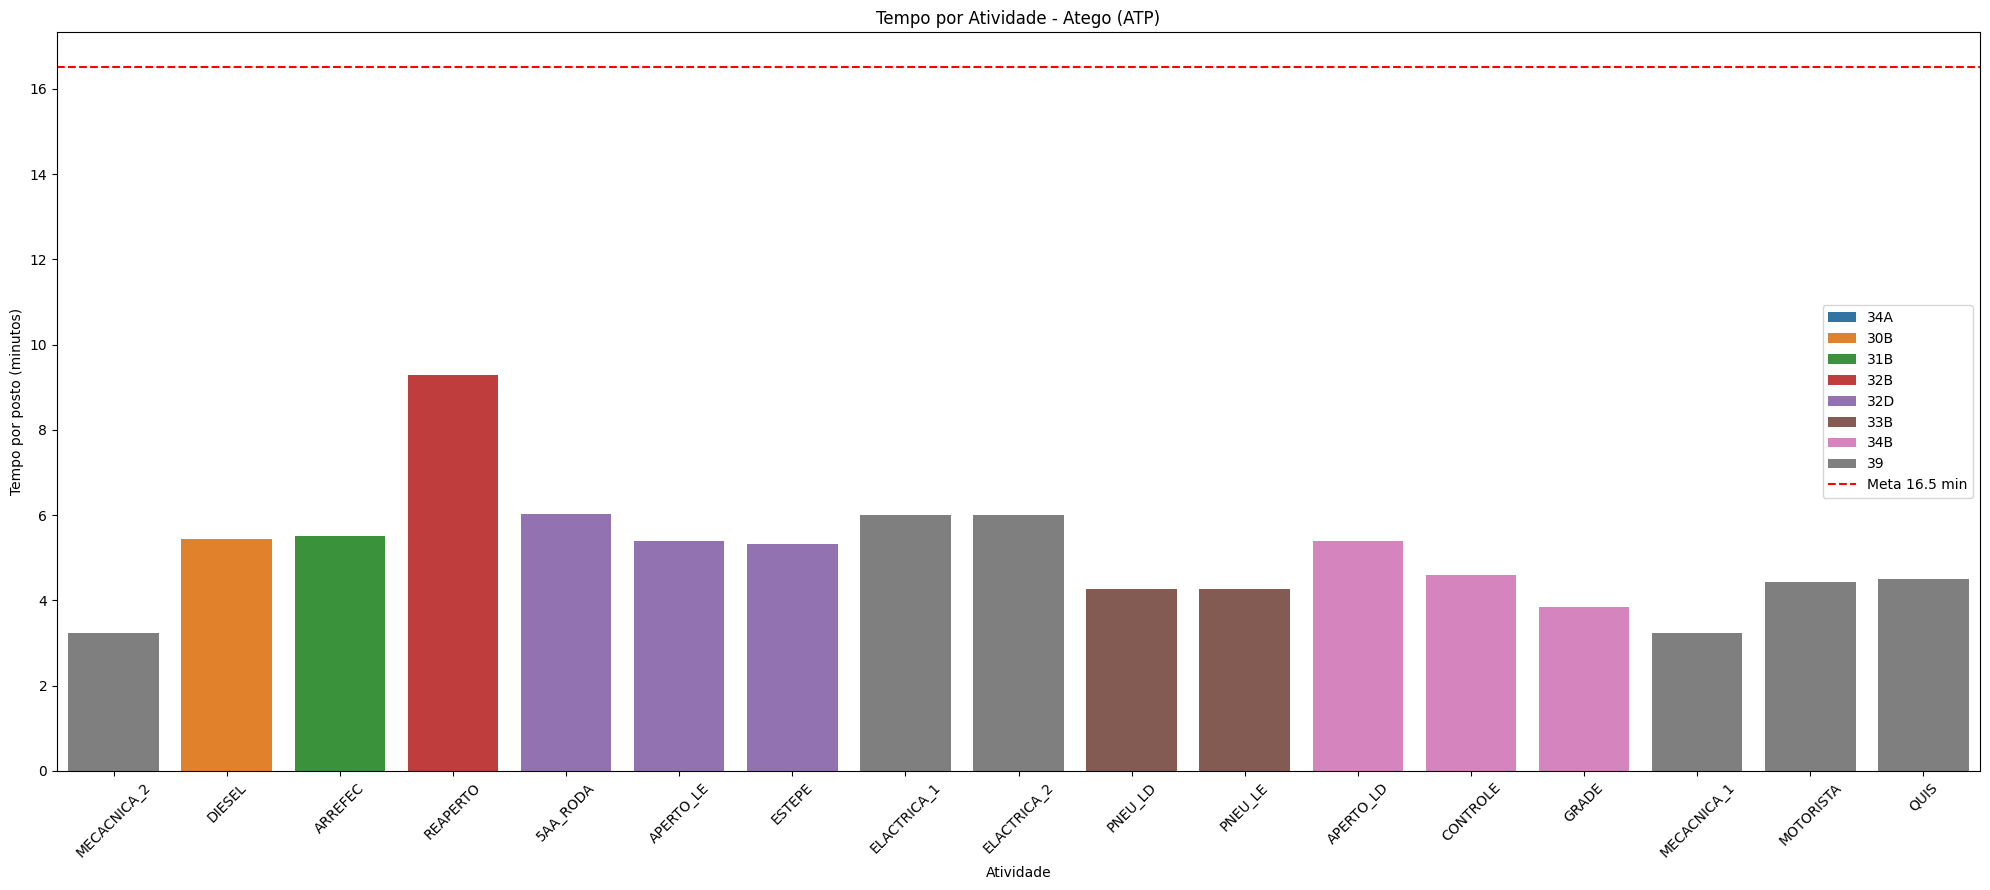

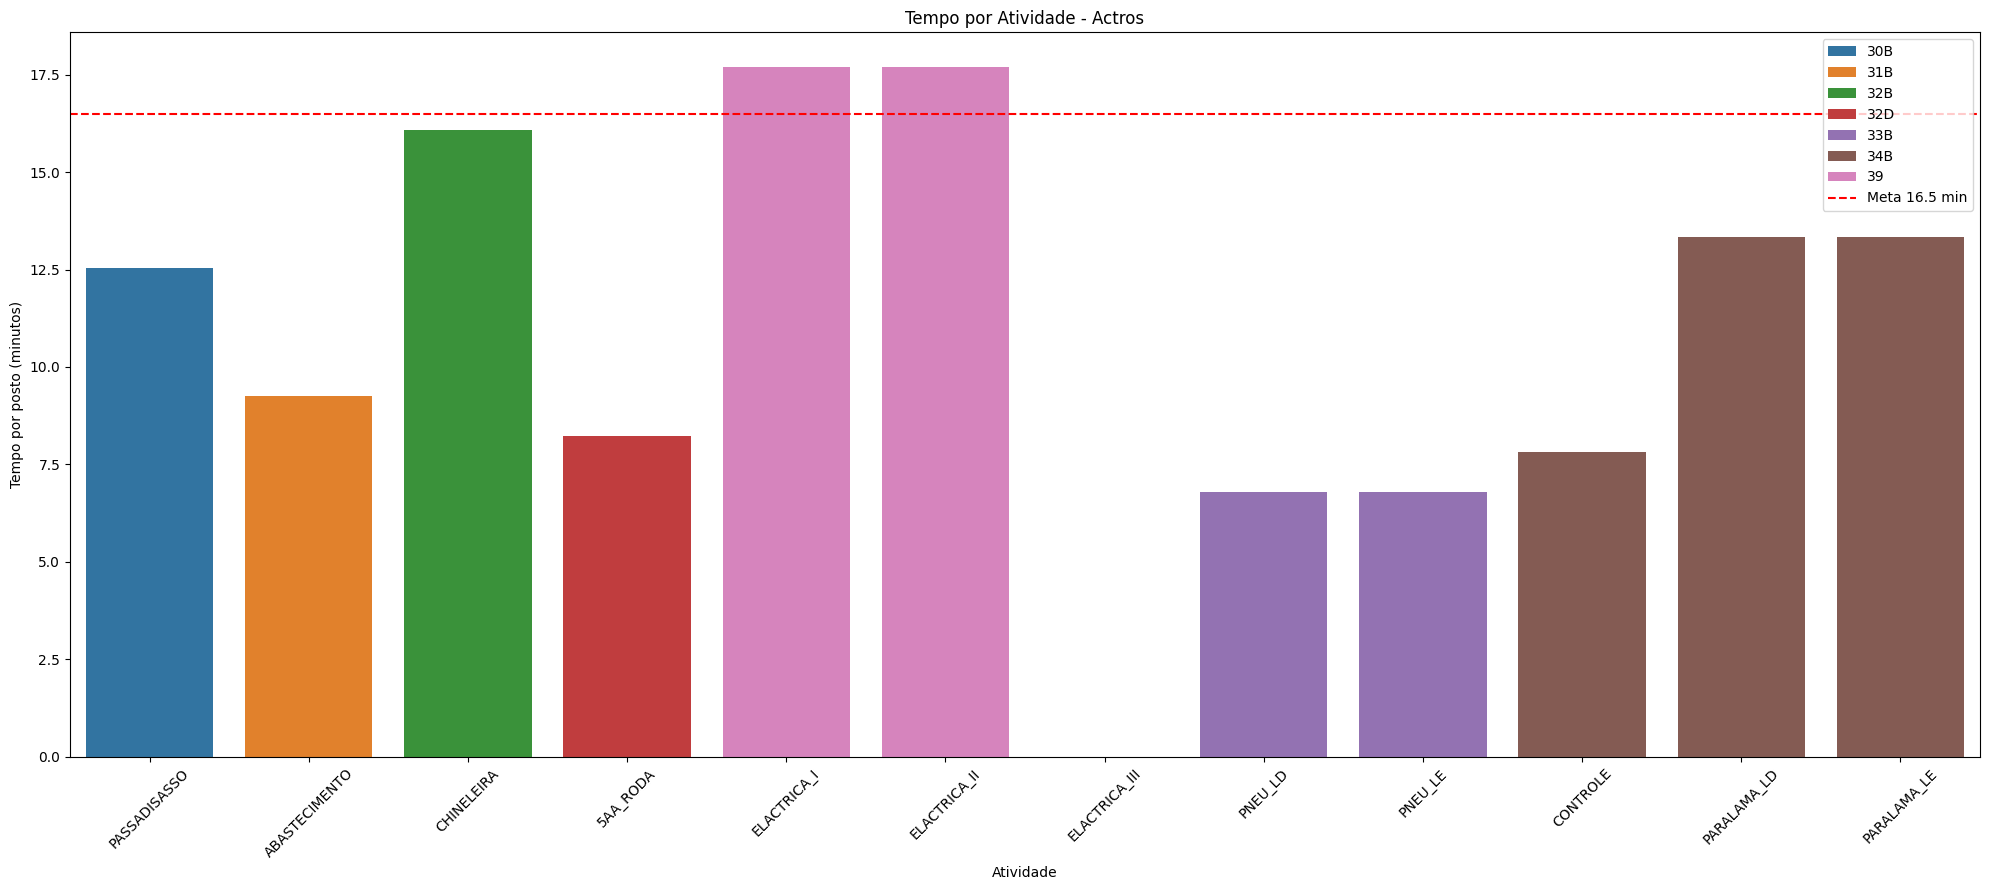

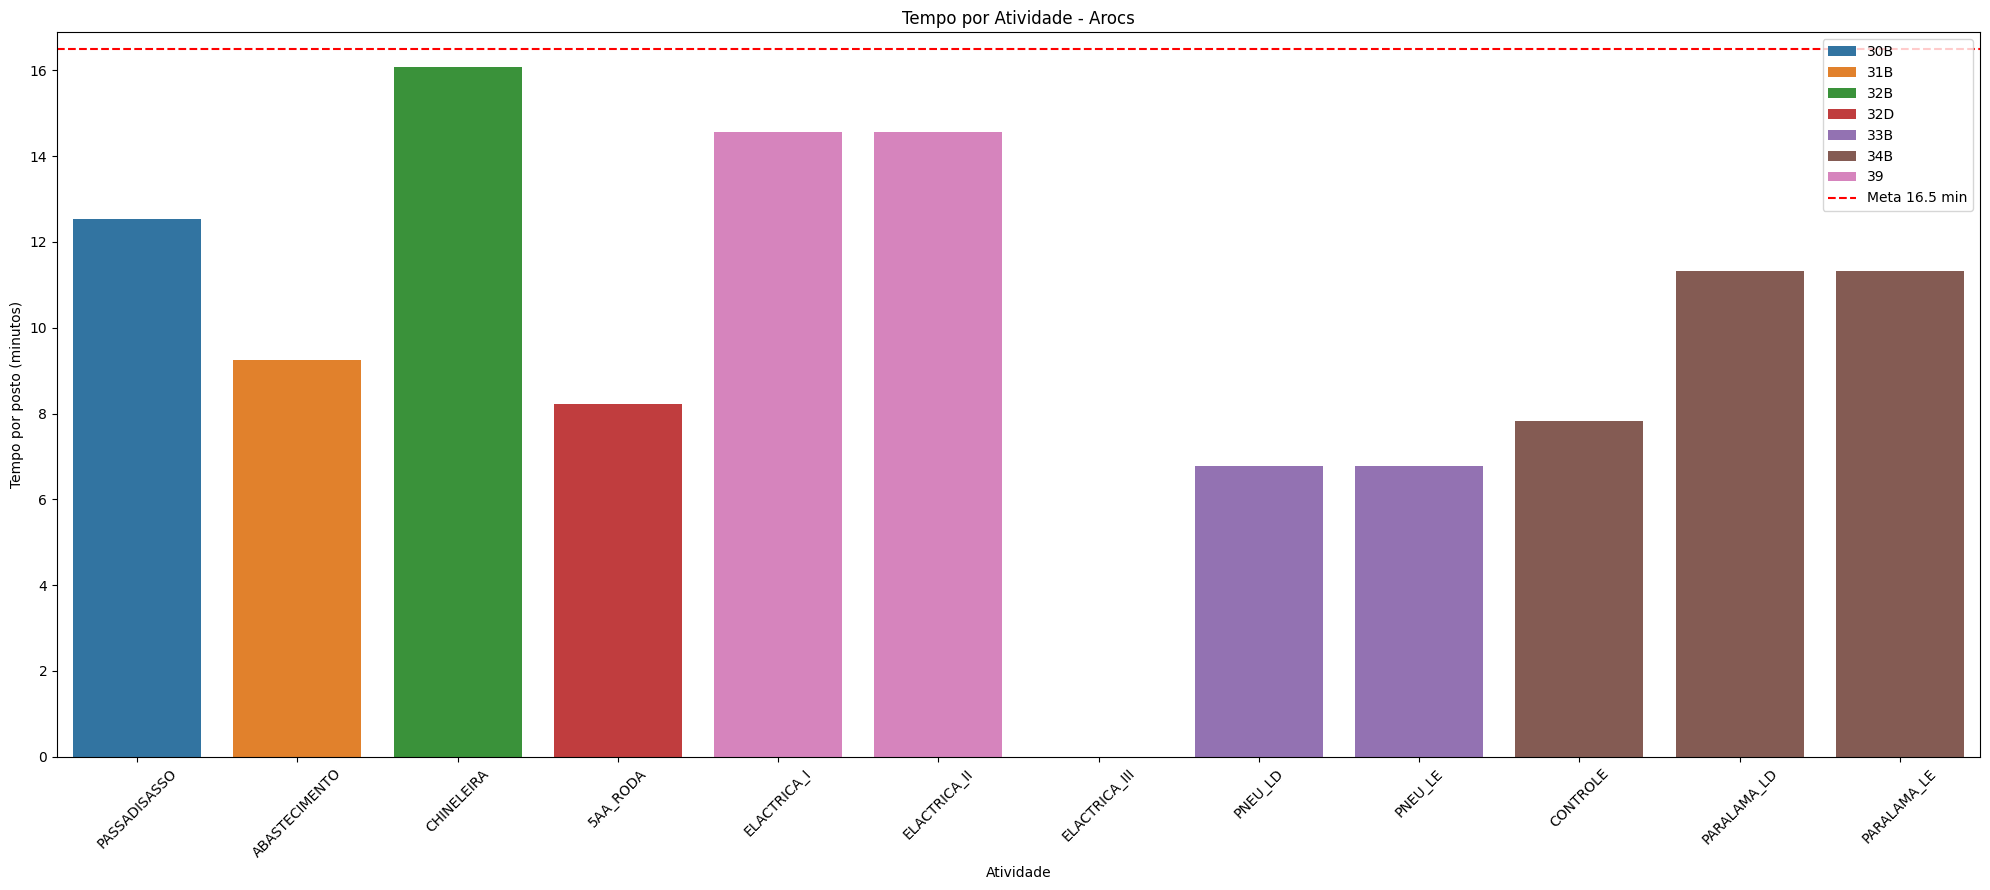

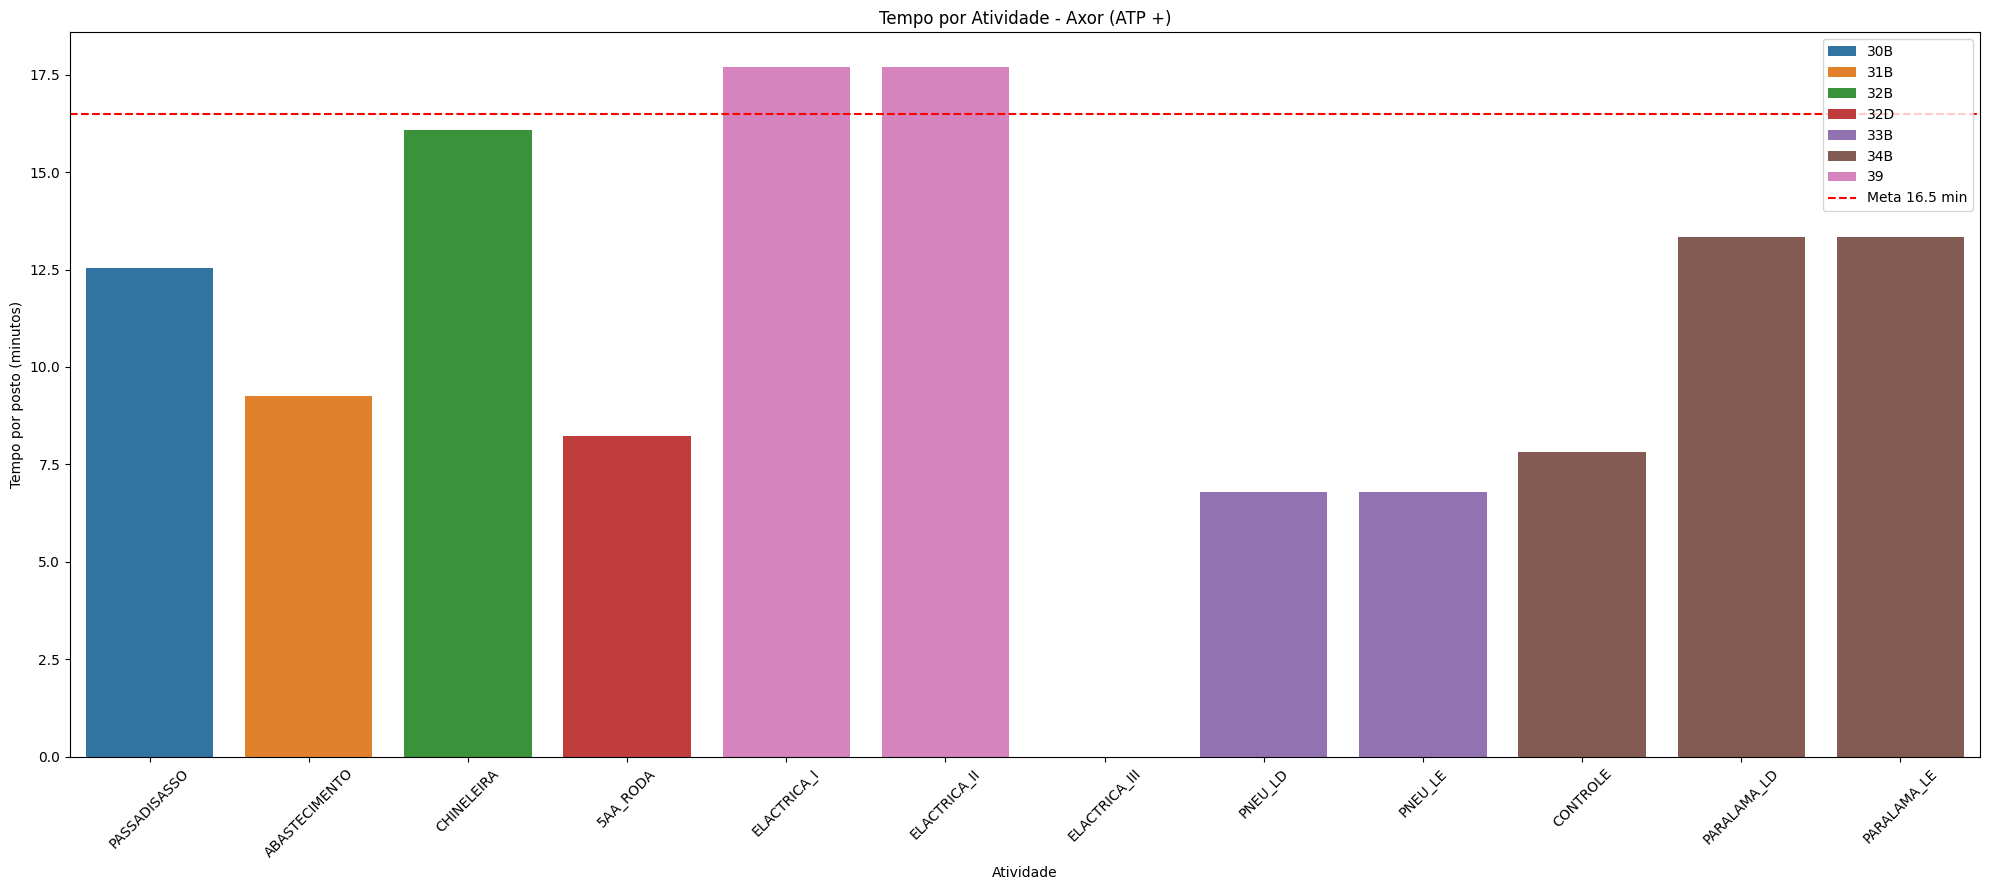

[<Figure size 2000x900 with 1 Axes>, <Figure size 2000x900 with 1 Axes>, <Figure size 2000x900 with 1 Axes>, <Figure size 2000x900 with 1 Axes>]


In [16]:
print(plot_tempo_atividades_por_modelo(MODELOS_CSV, ATIVIDADES_P1, ATIVIDADES_P2, get_process_times_from_csv))

Resumo da simulação em pdf

In [17]:

def gerar_resumo_pdf(df_log, TURN_DURATION, caminho_pdf):
    """
    Gera e salva um PDF com o resumo da simulação de um dia.
    """

    # 1. Quantidade de modelos por perna
    modelos_completos = df_log.groupby("nome").agg(
        perna=("perna", "first"),
        entrada_total=("entrada", "min"),
        saida_total=("saida", "max")
    )
    modelos_completos["tempo_total"] = modelos_completos["saida_total"] - modelos_completos["entrada_total"]
    producao_por_perna = modelos_completos["perna"].value_counts().sort_index()

    # 2. Tempo médio de produção por perna (em minutos)
    tempo_medio_producao = modelos_completos.groupby("perna")["tempo_total"].mean() / 60

    # 3. Takt time médio (em minutos)
    tempo_medio_por_posto = df_log.groupby(["perna", "posto"])["duracao"].mean()
    takt_time_medio = tempo_medio_por_posto.groupby("perna").mean() / 60

    # 4. Novo Takt time real por perna (em minutos)
    takt_time_real = (TURN_DURATION / producao_por_perna).sort_index() / 60

    # 5. Texto formatado
    linhas = []
    linhas.append("📄 RESUMO DA SIMULAÇÃO\n")
    linhas.append("Modelos produzidos por perna:")
    for perna, qtd in producao_por_perna.items():
        linhas.append(f"  - Perna {perna}: {qtd} modelos")

    linhas.append("\nTempo médio de produção por modelo:")
    for perna, tempo in tempo_medio_producao.items():
        linhas.append(f"  - Perna {perna}: {tempo:.2f} minutos")

    linhas.append("\nTakt time médio por posto:")
    for perna, takt in takt_time_medio.items():
        linhas.append(f"  - Perna {perna}: {takt:.2f} minutos")

    linhas.append("\nNovo Takt time real (TURN_DURATION / produção):")
    for perna, takt in takt_time_real.items():
        linhas.append(f"  - Perna {perna}: {takt:.2f} minutos")

    # 6. Criação do PDF
    c = canvas.Canvas(caminho_pdf, pagesize=A4)
    width, height = A4

    c.setFont("Helvetica", 12)
    y = height - 40

    for linha in linhas:
        c.drawString(40, y, linha)
        y -= 20
        if y < 40:
            c.showPage()
            c.setFont("Helvetica", 12)
            y = height - 40

    c.save()
    print(f"📝 PDF salvo em: {caminho_pdf}")

### ETAPA 05: Leitura das sequências e geração de resultados

🗓️ Dias selecionados (10 a partir de 2025-04-01):
  - 2025-04-01
  - 2025-04-02
  - 2025-04-03
  - 2025-04-04


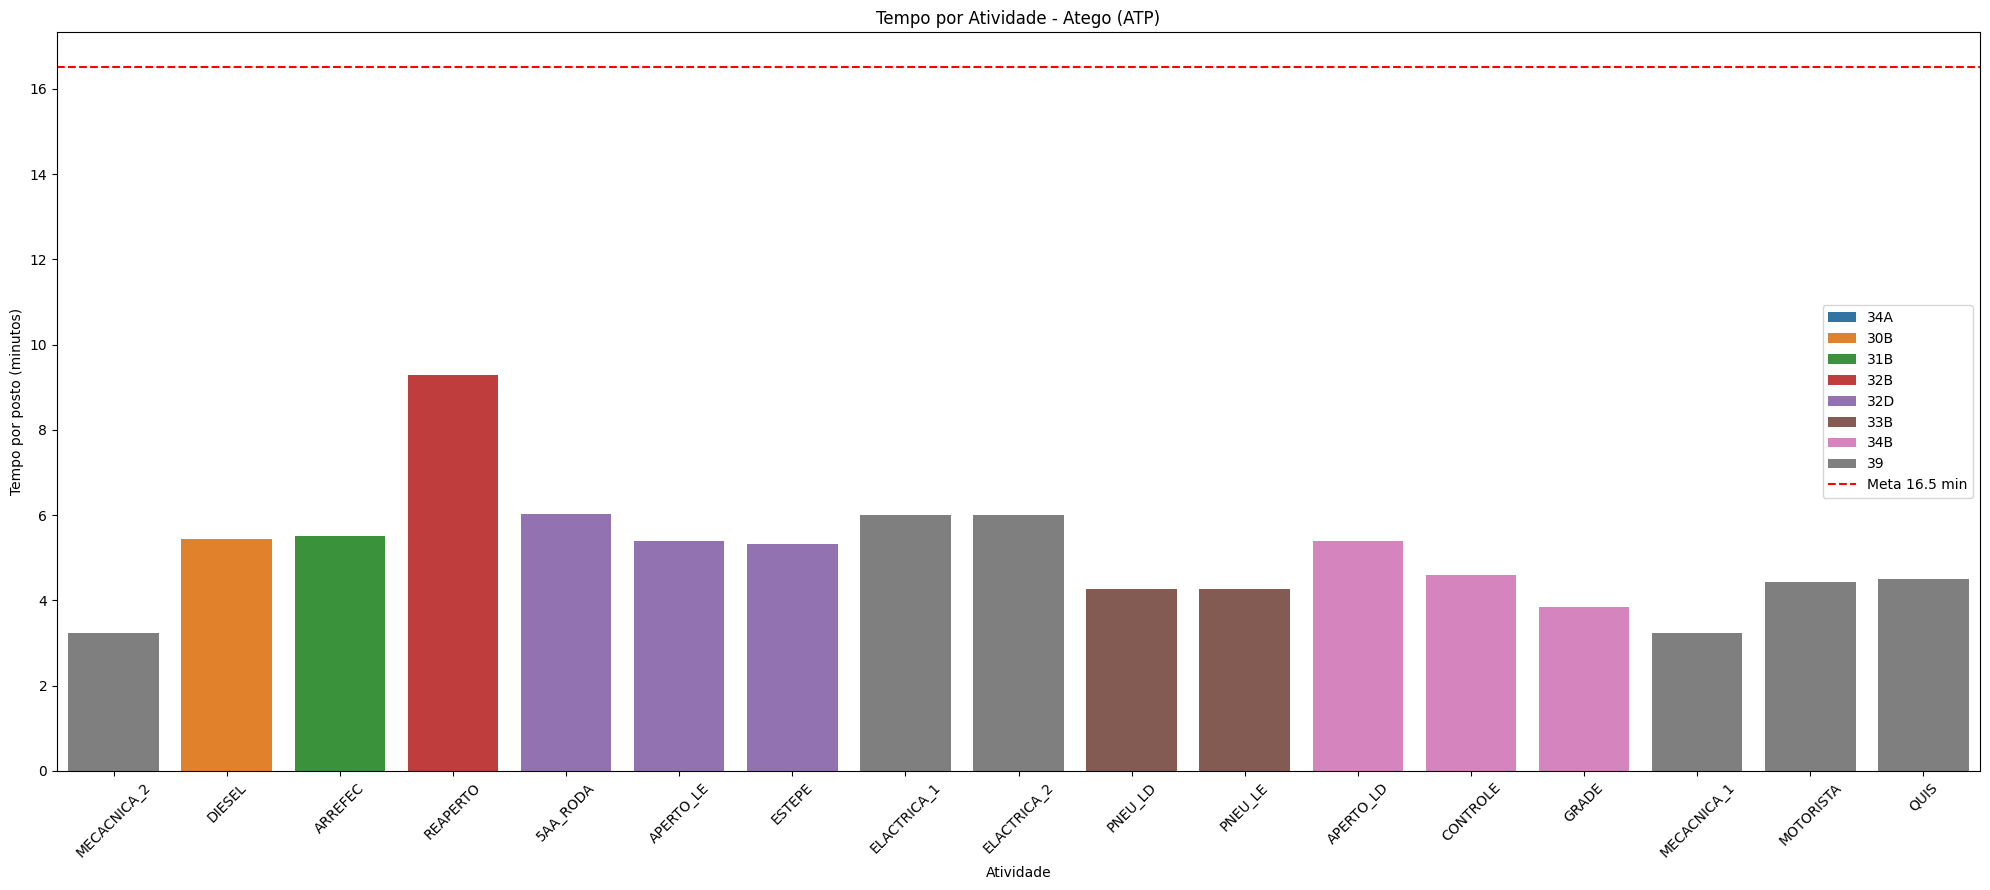

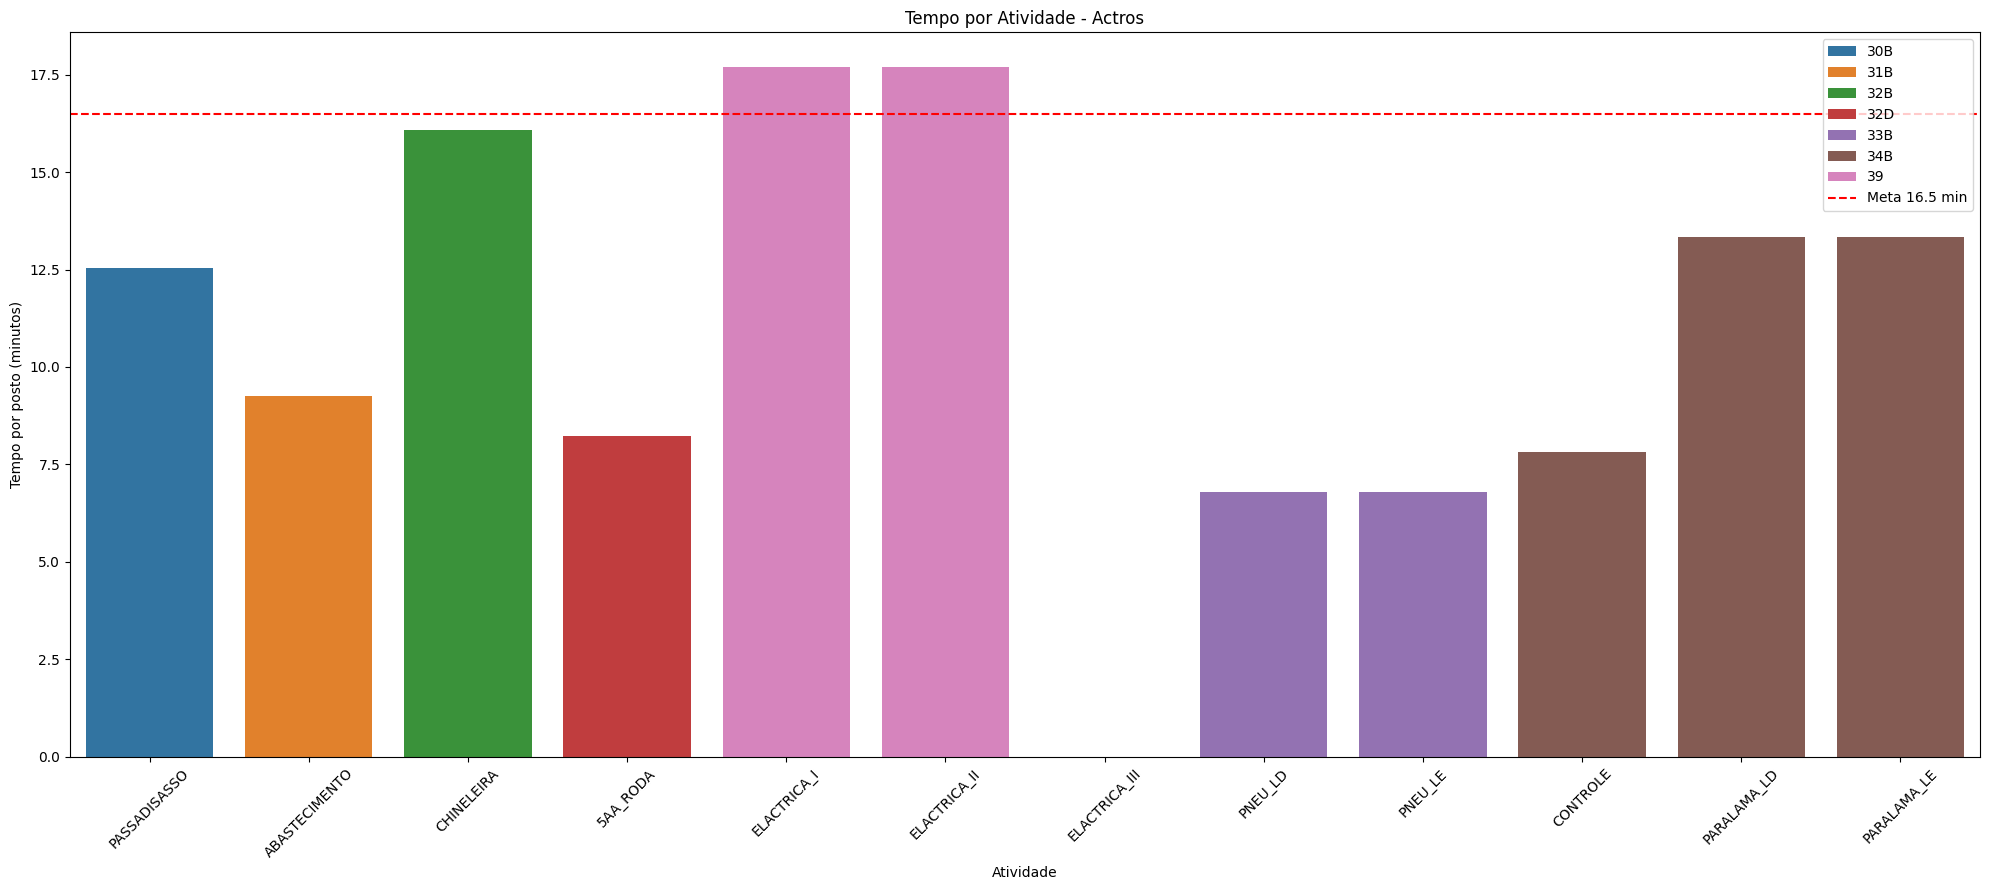

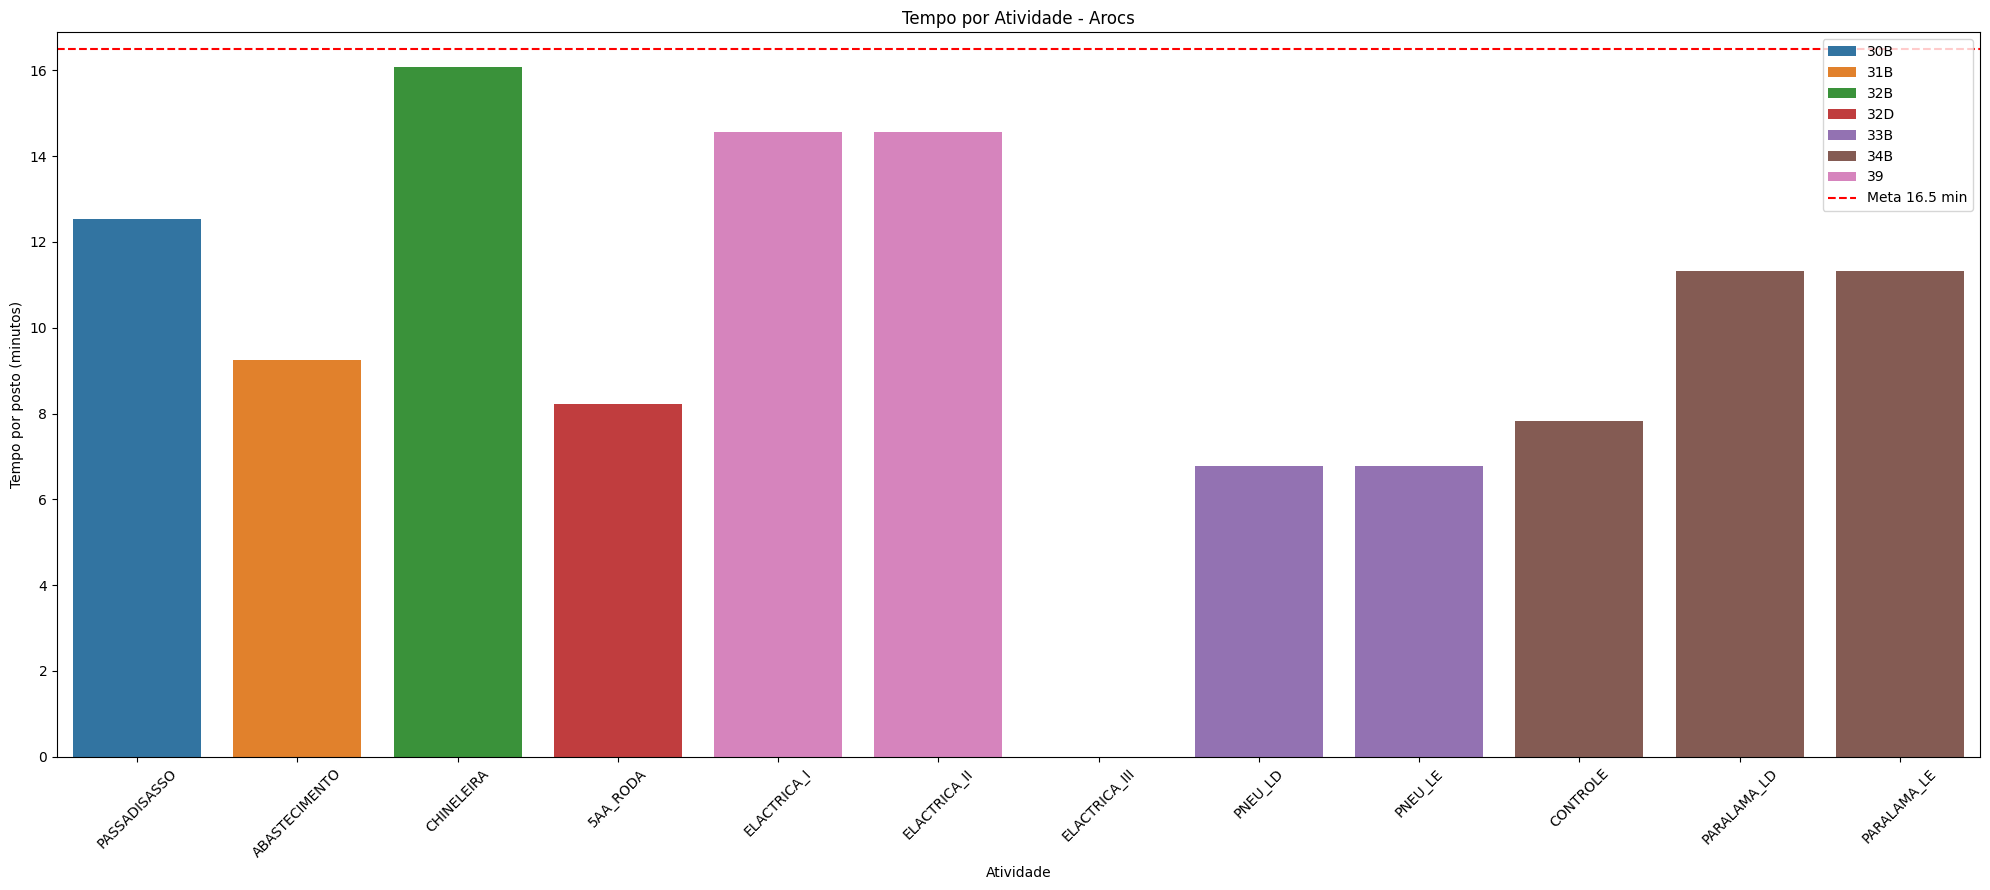

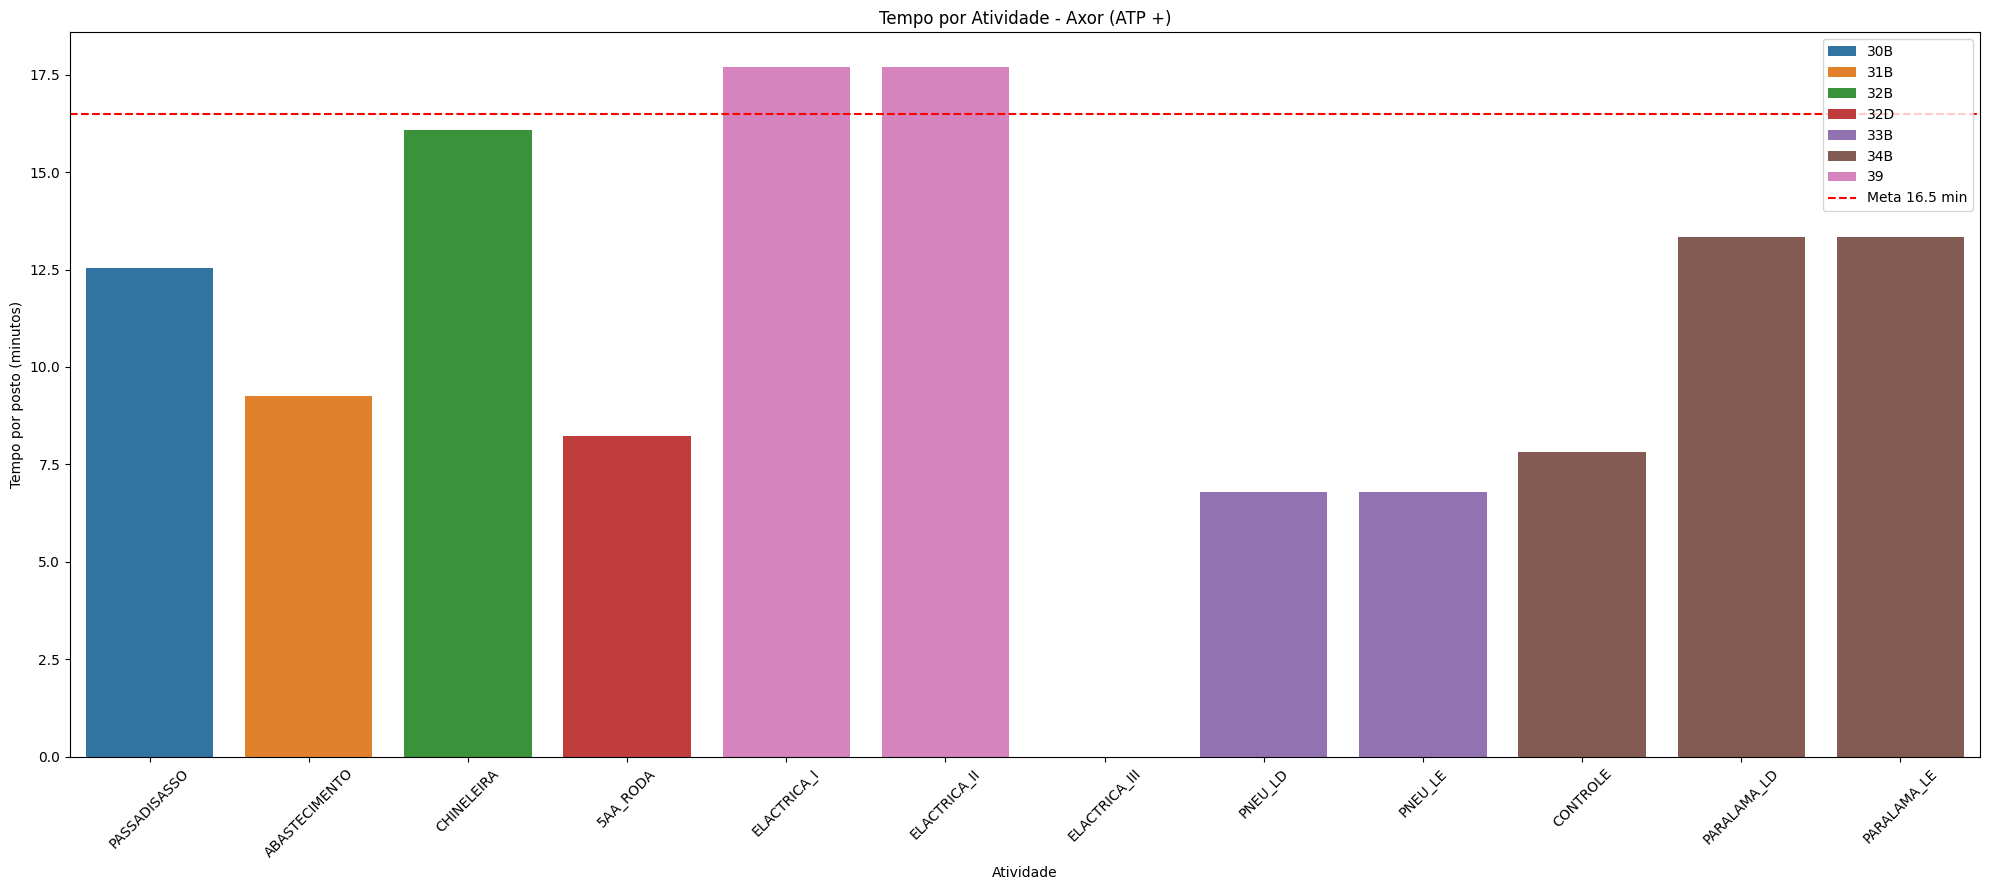


🔄 Processando o dia: 2025-04-01
✅ Já processado: 2025-04-01

🔄 Processando o dia: 2025-04-02
✅ Já processado: 2025-04-02

🔄 Processando o dia: 2025-04-03
✅ Já processado: 2025-04-03

🔄 Processando o dia: 2025-04-04
✅ Já processado: 2025-04-04


In [18]:

# Lê o arquivo Excel com os dados de produção
df_sequencia = pd.read_excel("todas_sequencias.xlsx")

# Converte a coluna de data
df_sequencia['Data Entrada Linha'] = pd.to_datetime(df_sequencia['Data Entrada Linha'])

# Define data de início (ajuste conforme necessário!)
data_inicio = date(2025, 4, 1)

# Obtém os dias únicos ordenados
dias_unicos = sorted(df_sequencia['Data Entrada Linha'].dt.date.unique())

# Filtra os dias a partir da data de início
dias_filtrados = [d for d in dias_unicos if d >= data_inicio][:4]

print(f"🗓️ Dias selecionados (10 a partir de {data_inicio}):")
for d in dias_filtrados:
    print(f"  - {d}")

# Cria pasta principal se não existir
os.makedirs("logs_C2", exist_ok=True)

# Salvando tempo por atividades
figs = plot_tempo_atividades_por_modelo(MODELOS_CSV, ATIVIDADES_P1, ATIVIDADES_P2, get_process_times_from_csv)
for i, fig in enumerate(figs, start=1):
    fig.savefig(f"logs_C2/atividades_modelo{i}.png", dpi=300, bbox_inches="tight")
    plt.close(fig)


# Loop por dia
for dia in dias_filtrados:
    log_entrada_saida = []
    print(f"\n🔄 Processando o dia: {dia}")
    
    pasta_dia = f"logs_C2/{dia}"
    nome_csv = f"{pasta_dia}/log_{dia}.csv"

    # Se já tiver o CSV salvo, pula o dia
    if os.path.exists(nome_csv):
        print(f"✅ Já processado: {dia}")
        continue

    os.makedirs(pasta_dia, exist_ok=True)

    # Filtra dados do dia
    df_dia = df_sequencia[df_sequencia['Data Entrada Linha'].dt.date == dia].copy()
    df_dia['Baumuster_7dig'] = df_dia['Baumuster'].astype(str).str[:7]
    sequencia_modelos = df_dia['Baumuster_7dig'].tolist()

    # Simula
    
    df_log = simulacao_linha(sequencia_modelos, MODELOS_CSV, POSTOS, TAKT_TIME, TURN_DURATION)

    # Gráficos e salvamento

    fig1 = plot_modelos_por_perna(df_log)
    fig1.savefig(f"{pasta_dia}/modelos_por_perna.png")

    fig2 = plot_modelos_produzidos(df_log)
    fig2.savefig(f"{pasta_dia}/modelos_produzidos.png")

    figs = plot_ocupacao_por_modelo_heatmap(df_log, TURN_DURATION)
    for i, fig in enumerate(figs, start=1):
        fig.savefig(f"{pasta_dia}/ocupacao_modelo_posto_P{i}.png", dpi=300, bbox_inches="tight")
        plt.close(fig)
    
    figs = plot_duracao_media_por_posto(df_log)
    for i, fig in enumerate(figs, start=1):
        fig.savefig(f"{pasta_dia}/duracao_media_por_posto_P{i}.png", dpi=300, bbox_inches="tight")
        plt.close(fig)

    fig5 = plot_sequencia_modelos_heatmap(df_log)
    fig5.savefig(f"{pasta_dia}/sequencia_dia.png", dpi=300, bbox_inches='tight')
    plt.close(fig5)

    fig6 = plot_boxplot_tempo_total_por_modelo(df_log)
    fig6.savefig(f"{pasta_dia}/boxplot_tempo_total_por_modelo.png", dpi=300, bbox_inches='tight')
    plt.close(fig6)


    # Salva CSV com o log
    df_log.to_csv(nome_csv, index=False)
    print(f"📁 Log salvo em: {nome_csv}")

    # (Opcional) Salva PDF com o resumo
    caminho_pdf = f"{pasta_dia}/resumo_simulacao.pdf"
    gerar_resumo_pdf(df_log, TURN_DURATION,caminho_pdf)
